# Differend compression algorithms for Weight-Sharing study

In [95]:
PATH_PREFIX = '../../../'
import sys
sys.path.append(PATH_PREFIX)

In [96]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import math
import yaml
import csv
from utils.plot import *
from utils.fitness_controller import FitnessController
from compress_optim import CompressConfig, load_comp_config, fit_from_vals

Settings

In [97]:
NET_TYPE = 'tanh'


ACC_TRESHOLD = 0.01
FOLDERS_EXP = [
    {'path': os.path.join(PATH_PREFIX, f'results/lenet_{NET_TYPE}_compress_50_extrem_dynamic/'), 'type': 'K-Means'},
    {'path': os.path.join(PATH_PREFIX, f'results/lenet_{NET_TYPE}_compress_50_dynamic_mbk/'), 'type': 'Mini-Batch K-Means'},
    {'path': os.path.join(PATH_PREFIX, f'results/lenet_{NET_TYPE}_compress_50_dynamic_gmm/'), 'type': 'GMM'}
    ]

FILE_FILT_SHOW = [
    'GA_save.csv', 
    'PSO_save.csv',
    'BH_save.csv',
]

SAVE_FILES = {
    'RND_save.csv': 'RND',
    'PSO_save.csv': 'PSO',
    'GA_save.csv': 'GA',
    'BH_save.csv': 'BH',
}

Loading data

In [98]:
data_complete = {
    'accuracy': [],
    'accuracy_loss': [],
    'compression': [],
    'type': [],
    'tar_type': [],
    'repr': [],
    'share_t': [],
    'acc_t': []
}

for experiment in FOLDERS_EXP:

    exp_dirs = [name for name in os.listdir(experiment['path']) if os.path.isdir(os.path.join(experiment['path'], name))]

    # load config
    with open(os.path.join(experiment['path'], 'experiment_setting.yaml'), 'r') as config:
        load_comp_config(yaml.safe_load(config))
    
    print(experiment['path'])

    for dir in exp_dirs:

        for file in [x for x in os.listdir(os.path.join(experiment['path'], dir)) if x in FILE_FILT_SHOW]:
            
            # loading the data
            save_df = pd.read_csv(os.path.join(experiment['path'], dir, file))           

            data_complete['accuracy'] += list(save_df['accuracy'])
            data_complete['accuracy_loss'] += list(save_df['accuracy_loss'])
            data_complete['compression'] += list(save_df['compression'])
            data_complete['type'] += [SAVE_FILES[file] for _ in range(len(save_df.index))] 
            data_complete['tar_type'] += [experiment['type'] for _ in range(len(save_df.index))]
            data_complete['repr'] += list(save_df['representation'] if 'representation' in save_df.columns else save_df['chromosome'])
            data_complete['share_t'] += list(save_df['share_t'])
            data_complete['acc_t'] += list(save_df['acc_t'])
            
data_complete = pd.DataFrame(data_complete)

../../../results/lenet_tanh_compress_50_extrem_dynamic/
../../../results/lenet_tanh_compress_50_dynamic_mbk/
../../../results/lenet_tanh_compress_50_dynamic_gmm/


In [99]:
data_complete['accuracy_loss'] *= 100

Plot pareto lines

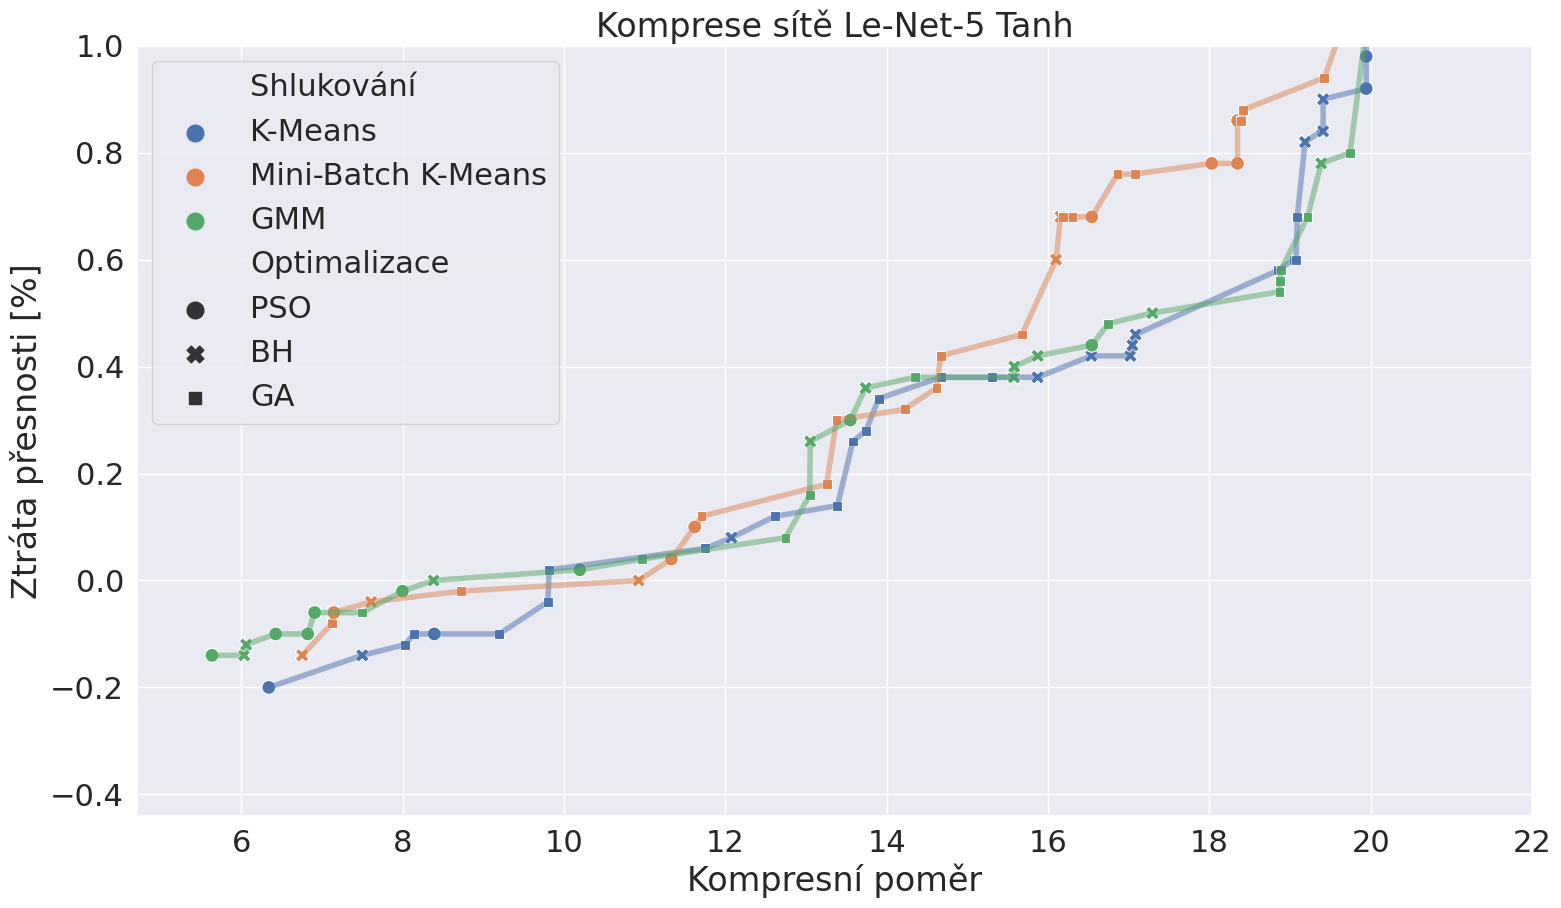

In [100]:
pareto_data = {
    'accuracy': [],
    'accuracy_loss': [],
    'compression': [],
    'type': [],
    'tar_type': [],
    'repr': []
}

pareto_data = pd.DataFrame(pareto_data)

for prec_type in ['K-Means', 'Mini-Batch K-Means', 'GMM']:
    pareto_data = pareto_data.append(pareto_from_df(data_complete[data_complete['tar_type'] == prec_type]), ignore_index=True)

pareto_data.to_csv(f'lenet_clust_pareto_{NET_TYPE}.csv')

pareto_data = pareto_data.rename(columns={"type": "Optimalizace", "tar_type": "Shlukování"})

sns.set(rc={'figure.figsize': (18, 10)}, font_scale=2)
plt.rc('font', size=25)
#sns.lmplot(data=pareto_data, x='compression', y='accuracy_loss', hue='tar_type', order=2, size=7, aspect=1.6)
sns.lineplot(data=pareto_data, x='compression', y='accuracy_loss', hue='Shlukování', alpha=0.5, legend=False, linewidth=4)
sns.scatterplot(data=pareto_data, x='compression', y='accuracy_loss', style='Optimalizace', hue='Shlukování', s=100)
plt.ylabel('Ztráta přesnosti [%]')
plt.xlabel('Kompresní poměr')
plt.ylim(top=1)
plt.xlim(right=14 if NET_TYPE == 'relu' else 22)
plt.title(f'Komprese sítě Le-Net-5 { "ReLu" if NET_TYPE == "relu" else "Tanh"}')
plt.legend(markerscale=2)

os.makedirs(os.path.join(PATH_PREFIX, 'results/graphs/lenet/times'), exist_ok=True)
plt.savefig(os.path.join(PATH_PREFIX, 'results/graphs/lenet/times', f'lineplot_clust_algs_lenet_{NET_TYPE}.pdf'))

In [85]:
data_complete

,accuracy,accuracy_loss,compression,type,tar_type,repr,share_t,acc_t
0,0.9856,-0.10,4.799658,BH,K-Means,"[41, 36, 33, 22, 17]",1.306241,0.529571
1,0.9844,0.02,7.051173,BH,K-Means,"[4, 41, 31, 15, 27]",1.132172,0.531170
2,0.9854,-0.08,5.755292,BH,K-Means,"[15, 23, 33, 31, 13]",1.240606,0.530731
3,0.9858,-0.12,6.016206,BH,K-Means,"[14, 22, 17, 12, 20]",0.737406,0.526041
4,0.9830,0.16,6.319583,BH,K-Means,"[41, 21, 14, 6, 30]",0.764974,0.530041
...,...,...,...,...,...,...,...,...
40651,0.9764,0.82,9.703471,PSO,GMM,"[3, 41, 31, 6, 4]",1.255989,0.666223
40652,0.9708,1.38,10.760411,PSO,GMM,"[3, 43, 23, 4, 4]",1.258835,0.664465
40653,0.9550,2.96,10.751922,PSO,GMM,"[3, 49, 25, 3, 4]",1.124562,0.713649
40654,0.9506,3.40,12.816404,PSO,GMM,"[2, 43, 25, 4, 4]",1.092530,0.667008


In [86]:
time_data = {
    'type': [],
    'Čas': [],
    'time': [],
    'percent': []
}

tmp_df = data_complete.groupby('tar_type').mean()
tmp_df = tmp_df.reset_index()
for alg in ['K-Means', 'Mini-Batch K-Means', 'GMM']:
    row = tmp_df[tmp_df['tar_type'] == alg]
    time_data['type'] += [alg, alg]
    time_data['Čas'] += ['Shlukování', 'Přesnost']
    time_data['time'] += [row['share_t'].values[0], row['acc_t'].values[0]]
    time_sum = sum([row['share_t'].values[0], row['acc_t'].values[0]])
    time_data['percent'] += [row['share_t'].values[0]/time_sum, row['acc_t'].values[0]/time_sum]

time_data = pd.DataFrame(time_data)
time_data

,type,Čas,time,percent
0,K-Means,Shlukování,0.790077,0.603702
1,K-Means,Přesnost,0.518643,0.396298
2,Mini-Batch K-Means,Shlukování,0.115881,0.178922
3,Mini-Batch K-Means,Přesnost,0.531780,0.821078
4,GMM,Shlukování,1.208350,0.613794
5,GMM,Přesnost,0.760308,0.386206


Plot time ratios

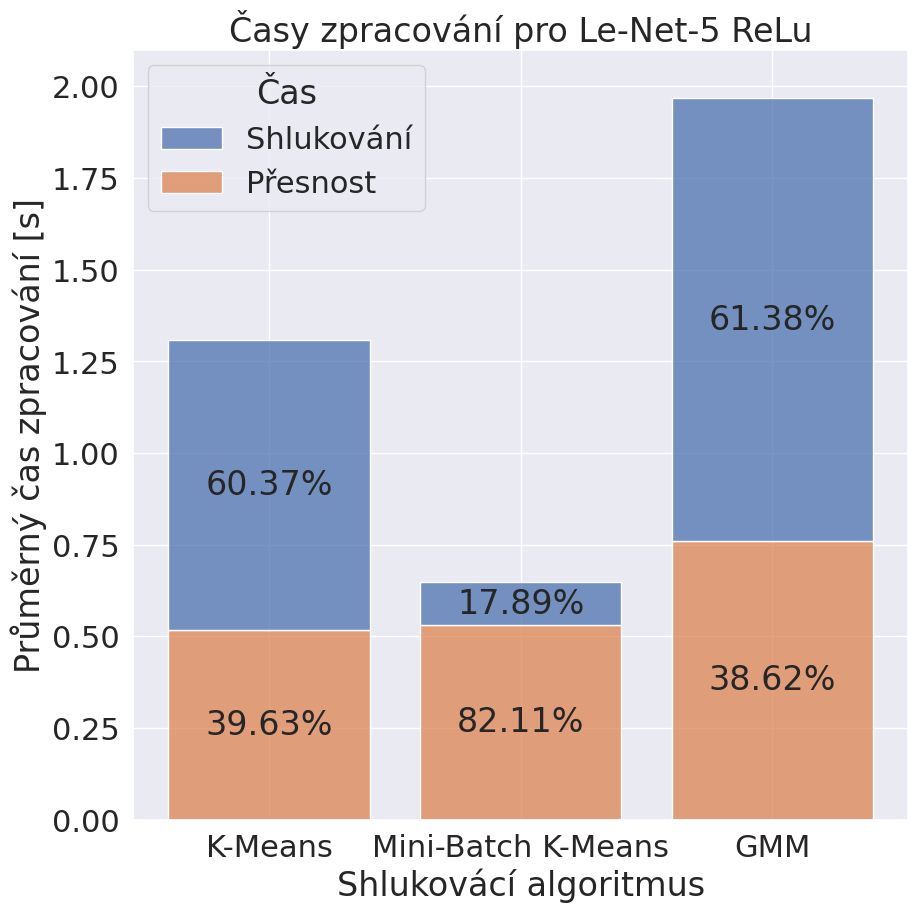

In [87]:
sns.set(rc={'figure.figsize': (10, 10)}, font_scale=2)
ax = sns.histplot(data=time_data, x='type', weights='time' ,hue='Čas', multiple='stack', shrink=.8, label='percent')
plt.xlabel('Shlukovácí algoritmus')
plt.ylabel('Průměrný čas zpracování [s]')
plt.title(f'Časy zpracování pro Le-Net-5 {"ReLu" if NET_TYPE == "relu" else "Tanh"}')
plt.ylim(top=2.1)

def truncate(n, decimals=0):
    multiplier = 10 ** decimals
    return int(n * multiplier) / multiplier

for c in ax.containers:

    # Optional: if the segment is small or 0, customize the labels
    labels = []
    for v in c:
        df_closest = time_data.iloc[(time_data['time']-v.get_height()).abs().argsort()[:1]]
        labels.append(f'{df_closest["percent"].values[0] * 100:0.2f}%')
    
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, labels=labels, label_type='center')

os.makedirs(os.path.join(PATH_PREFIX, 'results/graphs/lenet/times'), exist_ok=True)
plt.savefig(os.path.join(PATH_PREFIX, 'results/graphs/lenet/times', f'histplot_time_lenet_{NET_TYPE}.pdf'))

Plot share time variances

<AxesSubplot:xlabel='tar_type', ylabel='share_t'>

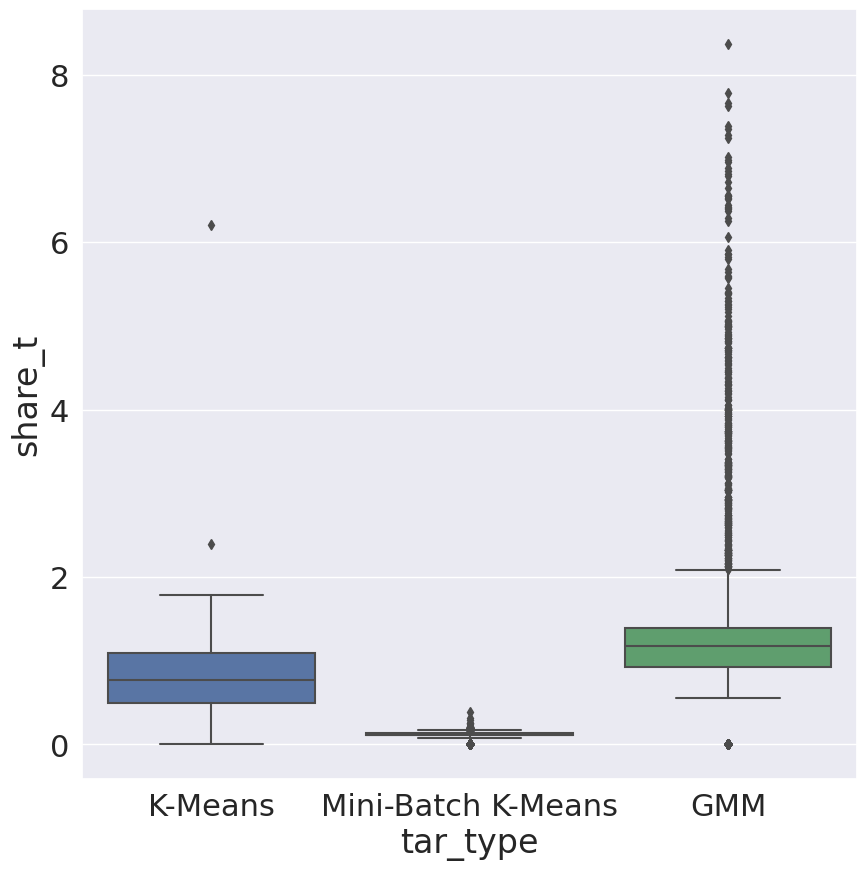

In [88]:
sns.boxplot(data=data_complete, x='tar_type', y='share_t')